In [1]:
# -------------------------------------------------
# Tight-binding model for trimer with magnetic flux
# -------------------------------------------------

from __future__ import print_function # python3 style print
from pythtb import *

import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

In [2]:
# define function to set up model for given (t0,s,phi,alpha)

def set_model(t0,s,phi,alpha):
    # coordinate space is 2D
    lat=[[1.0,0.0],[0.0,1.0]]
    # Finite model with three orbitals forming a triangle at unit
    # distance from the origin
    sqr32=np.sqrt(3.)/2.
    orb=np.zeros((3,2),dtype=float)
    orb[0,:]=[0.,1.]          # orbital at top vertex
    orb[1,:]=[-sqr32,-0.5]    # orbital at lower left
    orb[2,:]=[ sqr32,-0.5]    # orbital at lower right
      
    # compute hoppings [t_01, t_12, t_20]
    # s is distortion amplitude; phi is "pseudorotation angle"
    tpio3=2.0*np.pi/3.0
    t=[ t0+s*np.cos(phi), t0+s*np.cos(phi-tpio3), t0+s*np.cos(phi-2.0*tpio3) ]
  
    # alpha is fraction of flux quantum passing through the triangle
    # magnetic flux correction, attached to third bond
    t[2]=t[2]*np.exp((1.j)*alpha)
  
    # set up model (leave site energies at zero)
    my_model=tbmodel(0,2,lat,orb)
    my_model.set_hop(t[0],0,1)
    my_model.set_hop(t[1],1,2)
    my_model.set_hop(t[2],2,0)
    return(my_model)

In [3]:
# define function to return eigenvectors for given (t0,s,phi,alpha)

def get_evecs(t0,s,phi,alpha):
    my_model=set_model(t0,s,phi,alpha)
    (eval,evec)=my_model.solve_all(eig_vectors=True)
    return(evec)        # evec[bands,orbitals]

In [4]:
# begin regular execution

# for the purposes of this problem we keep t0 and s fixed
t0 =-1.0
s  =-0.4
ref_model=set_model(t0,s,0.,1.)  # reference with phi=alpha=0
ref_model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 0
r-space dimension           = 2
number of spin components   = 1
periodic directions         = []
number of orbitals          = 3
number of electronic states = 3
lattice vectors:
 #  0  ===>  [     1.0 ,     0.0 ]
 #  1  ===>  [     0.0 ,     1.0 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,     1.0 ]
 #  1  ===>  [  -0.866 ,    -0.5 ]
 #  2  ===>  [   0.866 ,    -0.5 ]
site energies:
 #  0  ===>       0.0
 #  1  ===>       0.0
 #  2  ===>       0.0
hoppings:
<  0 | H |  1 >     ===>     -1.4 +     0.0 i
<  1 | H |  2 >     ===>     -0.8 +     0.0 i
<  2 | H |  0 >     ===>  -0.4322 -  0.6732 i
hopping distances:
|  pos(  0 )  - pos(  1 ) |  =    1.7321
|  pos(  1 )  - pos(  2 ) |  =    1.7321
|  pos(  2 )  - pos(  0 ) |  =    1.7321



In [5]:
# define two pi
twopi=2.*np.pi

In [6]:
# compute Berry phase for phi loop explicitly at alpha=pi/3

alpha=np.pi/3.
n_phi=60
psi=np.zeros((n_phi,3),dtype=complex)    # initialize wavefunction array
for i in range(n_phi):
    phi=float(i)*twopi/float(n_phi)        # 60 equal intervals
    psi[i]=get_evecs(t0,s,phi,alpha)[0]    # psi[i] is short for psi[i,:]
prod=1.+0.j                              # final [0] picks out band 0
for i in range(1,n_phi):
    prod=prod*np.vdot(psi[i-1],psi[i]) # <psi_0|psi_1>...<psi_58|psi_59>
prod=prod*np.vdot(psi[-1],psi[0])    # include <psi_59|psi_0>
berry=-np.angle(prod)                # compute Berry phase
print("Explcitly computed phi Berry phase at alpha=pi/3 is %6.3f"% berry)

Explcitly computed phi Berry phase at alpha=pi/3 is -0.116


In [7]:
# compute Berry phases for phi loops for several alpha values
# using pythtb wf_array() method

alphas=np.linspace(0.,twopi,13)   # 0 to 2pi in 12 increments
berry_phi=np.zeros_like(alphas)      # same shape and type array (empty)
print("\nBerry phases for phi loops versus alpha")
for j,alpha in enumerate(alphas):

  # let phi range from 0 to 2pi in equally spaced steps
  n_phi=61
  phit=np.linspace(0.,twopi,n_phi)

  # set up empty wavefunction array object using pythtb wf_array()
  # creates 1D array of length [n_phi], with hidden [nbands,norbs]
  evec_array=wf_array(ref_model,[n_phi])

  # run over values of phi and fill the array
  for k,phi in enumerate(phit[0:-1]):    # skip last point of loop
    evec_array[k]=get_evecs(t0,s,phi,alpha)
  evec_array[-1]=evec_array[0]   # copy first point to last point of loop

  # now compute and store the Berry phase
  berry_phi[j]=evec_array.berry_phase([0])   # [0] specifices lowest band
  print("%3d %7.3f %7.3f"% (j, alpha, berry_phi[j]))


Berry phases for phi loops versus alpha
  0   0.000  -0.000
  1   0.524  -0.049
  2   1.047  -0.116
  3   1.571  -0.237
  4   2.094  -0.509
  5   2.618  -1.263
  6   3.142  -3.142
  7   3.665   1.263
  8   4.189   0.509
  9   4.712   0.237
 10   5.236   0.116
 11   5.760   0.049
 12   6.283   0.000


In [8]:
# compute Berry phases for alpha loops for several phi values
# using pythtb wf_array() method

phis=np.linspace(0.,twopi,13)   # 0 to 2pi in 12 increments
berry_alpha=np.zeros_like(phis)
print("\nBerry phases for alpha loops versus phi")
for j,phi in enumerate(phis):
  n_alpha=61
  alphat=np.linspace(0.,twopi,n_alpha)
  evec_array=wf_array(ref_model,[n_alpha])
  for k,alpha in enumerate(alphat[0:-1]):
    evec_array[k]=get_evecs(t0,s,phi,alpha)
  evec_array[-1]=evec_array[0]
  berry_alpha[j]=evec_array.berry_phase([0])
  print("%3d %7.3f %7.3f"% (j, phi, berry_alpha[j]))


Berry phases for alpha loops versus phi
  0   0.000  -0.518
  1   0.524  -0.185
  2   1.047  -0.000
  3   1.571   0.185
  4   2.094   0.518
  5   2.618   1.039
  6   3.142   1.671
  7   3.665   2.374
  8   4.189   3.142
  9   4.712  -2.374
 10   5.236  -1.671
 11   5.760  -1.039
 12   6.283  -0.518


In [9]:
# now illustrate use of wf_array() to set up 2D array
# recompute Berry phases and compute Berry curvature

n_phi=61
n_alp=61
n_cells=(n_phi-1)*(n_alp-1)
phi=np.linspace(0.,twopi,n_phi)
alp=np.linspace(0.,twopi,n_alp)
evec_array=wf_array(ref_model,[n_phi,n_alp])  # empty 2D wavefunction array
for i in range(n_phi):
  for j in range(n_alp):
    evec_array[i,j]=get_evecs(t0,s,phi[i],alp[j])
evec_array.impose_loop(0)   # copy first to last points in each dimension
evec_array.impose_loop(1)

bp_of_alp=evec_array.berry_phase([0],0)  # compute phi Berry phases vs. alpha
bp_of_phi=evec_array.berry_phase([0],1)  # compute alpha Berry phases vs. phi

# compute 2D array of Berry fluxes for band 0
flux=evec_array.berry_flux([0])
print("\nFlux = %7.3f = 2pi * %7.3f"% (flux, flux/twopi))
curvature=evec_array.berry_flux([0],individual_phases=True)*float(n_cells)


Flux =   6.283 = 2pi *   1.000


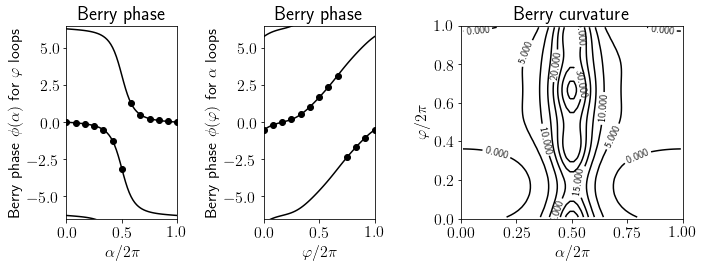

In [10]:
# plots

fig,ax=plt.subplots(1,3,figsize=(10,4),gridspec_kw={'width_ratios':[1,1,2]})
(ax0,ax1,ax2)=ax

ax0.set_xlim(0.,1.)
ax0.set_ylim(-6.5,6.5)
ax0.set_xlabel(r"$\alpha/2\pi$")
ax0.set_ylabel(r"Berry phase $\phi(\alpha)$ for $\varphi$ loops")
ax0.set_title("Berry phase")
for shift in (-twopi,0.,twopi):
  ax0.plot(alp/twopi,bp_of_alp+shift,color='k')
ax0.scatter(alphas/twopi,berry_phi,color='k')

ax1.set_xlim(0.,1.)
ax1.set_ylim(-6.5,6.5)
ax1.set_xlabel(r"$\varphi/2\pi$")
ax1.set_ylabel(r"Berry phase $\phi(\varphi)$ for $\alpha$ loops")
ax1.set_title("Berry phase")
for shift in (-twopi,0.,twopi):
  ax1.plot(phi/twopi,bp_of_phi+shift,color='k')
ax1.scatter(phis/twopi,berry_alpha,color='k')

X=alp[0:-1]/twopi + 0.5/float(n_alp-1)
Y=phi[0:-1]/twopi + 0.5/float(n_phi-1)
cs=ax2.contour(X,Y,curvature,colors='k')
ax2.clabel(cs, inline=1, fontsize=10)
ax2.set_title("Berry curvature")
ax2.set_xlabel(r"$\alpha/2\pi$")
ax2.set_xlim(0.,1.)
ax2.set_ylim(0.,1.)
ax2.set_ylabel(r"$\varphi/2\pi$")

fig.tight_layout()
#fig.savefig("trimer.pdf")

plt.show()